<a href="https://colab.research.google.com/github/omar-roa/deep-learning/blob/main/02%20-%20preprocesado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Librerías

In [ ]:
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
def matrix_conf(y_test, y_pred, labels):
    cm = confusion_matrix(y_test, y_pred)

    # Normalizar
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Graficar
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(cmn, cmap="Blues", annot=True, fmt='.3f', xticklabels=labels, yticklabels=labels)
    plt.ylabel('Real')
    plt.xlabel('Predicción')
    plt.show(block=False)

    return ax

# 1. Retomamos el dataset original



In [ ]:
%%capture
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-57BtQwaNxYvdkKVUJu0n15Kx3OwgJRj' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1-57BtQwaNxYvdkKVUJu0n15Kx3OwgJRj" -O SDN_Intrusion.csv && rm -rf /tmp/cookies.txt

In [ ]:
ds_or = pd.read_csv('/content/SDN_Intrusion.csv')

# 2. Comencemos a depurar el dataset

Como consecuencia de la exploración inicial de los datos, se han identificado algunos temas que deben ser abordados:
1.   El dataset contiene entradas atípicas
1.   ¿Hay características innecesarias para la definición del modelo?
1.   El tráfico benigno representa el doble de tráfico malicioso



In [ ]:
# Convertir las clases en variables numéricas
clases = list(ds_or['Class'].unique())

clases_dict = {}
dict_multi = {}

for i, c in enumerate (clases):
    clases_dict[c] = i
    dict_multi[i] = c

ds_v2 = ds_or.replace(clases_dict)
ds_v2['Class'].unique()

array([0, 1, 2, 3, 4])

Estos son los **labels** de las clases

In [ ]:
print(dict_multi)

{0: 'DDoS', 1: 'BENIGN', 2: 'Web Attack � Brute Force', 3: 'Web Attack � XSS', 4: 'Web Attack � Sql Injection'}


## El dataset contiene entradas en null

71 entradas presentan valor Null en la características **Flow Bytes/s**. Esto representa solo el **0.006 %** del dataset. Se eliminarán del dataset

In [ ]:
pd.isnull(ds_v2["Flow Bytes/s"]).value_counts()

False    1188262
True          71
Name: Flow Bytes/s, dtype: int64

In [ ]:
# Se crea una serie con entradas True para valores nulos
nulos = pd.isnull(ds_v2["Flow Bytes/s"]) 

# Filtrando el dataset
ds_drop = ds_or[nulos]

# Ninguno de los candidatos a descarte es un ataque (clase minoritaria)
ds_drop['Class'].value_counts()

BENIGN    71
Name: Class, dtype: int64

In [ ]:
# Eliminando las entradas inconsistentes
unn_drop = ds_drop['Unnamed: 0'].tolist()

ds_v3 = ds_v2

for i in unn_drop:
    ds_v3 = ds_v3.drop(ds_v3[ds_v3['Unnamed: 0'] == i].index)

In [ ]:
# Comprobamos que las nuevas dimensiones correspondan al número de datos normales
ds_v3.shape

(1188262, 80)

Verificamos que no hayan valores nulos

In [ ]:
pd.isnull(ds_v3["Flow Bytes/s"]).value_counts()

False    1188262
Name: Flow Bytes/s, dtype: int64

## El dataset contiene entradas infinitas

Identificamos 480 entradas con valor no finito en las característica **Flow Bytes/s** y **Flow Packets/s**


In [ ]:
with pd.option_context('display.max_rows', None,): 
    display(np.isfinite(ds_v3).sum())

Unnamed: 0                      1188262
 Destination Port               1188262
 Flow Duration                  1188262
 Total Fwd Packets              1188262
 Total Backward Packets         1188262
Total Length of Fwd Packets     1188262
 Total Length of Bwd Packets    1188262
 Fwd Packet Length Max          1188262
 Fwd Packet Length Min          1188262
 Fwd Packet Length Mean         1188262
 Fwd Packet Length Std          1188262
Bwd Packet Length Max           1188262
 Bwd Packet Length Min          1188262
 Bwd Packet Length Mean         1188262
 Bwd Packet Length Std          1188262
Flow Bytes/s                    1187782
 Flow Packets/s                 1187782
 Flow IAT Mean                  1188262
 Flow IAT Std                   1188262
 Flow IAT Max                   1188262
 Flow IAT Min                   1188262
Fwd IAT Total                   1188262
 Fwd IAT Mean                   1188262
 Fwd IAT Std                    1188262
 Fwd IAT Max                    1188262


Eliminaremos en primer lugar las entradas atípicas de **Flow Bytes/s**



In [ ]:
# Se crea una serie con entradas True para valores infinitos
finite = np.isfinite(ds_v3["Flow Bytes/s"]) 

# Filtrando el dataset
ds_drop = ds_v3[~finite]

# Los candidatos a descarte son poco representativos en sus correspondientes clases
ds_drop['Class'].value_counts()

1    471
0      9
Name: Class, dtype: int64

In [ ]:
# Eliminando las entradas inconsistentes
unn_drop = ds_drop['Unnamed: 0'].tolist()

for i in unn_drop:
    ds_v3 = ds_v3.drop(ds_v3[ds_v3['Unnamed: 0'] == i].index)

In [ ]:
# Comprobamos que las nuevas dimensiones correspondan al número de datos normales
ds_v3.shape

(1187782, 80)

Verificamos que no hayan valores infinitos

In [ ]:
np.isfinite(ds_v3["Flow Bytes/s"]).value_counts()

True    1187782
Name: Flow Bytes/s, dtype: int64

Ahora revisamos las entradas infinitas de **Flow Packets/s**. Pero ya no presenta entradas atípicas, eran las mismas que fueron eliminadas en la característica anterior

In [ ]:
# Se crea una serie con entradas True para valores infinitos
finite = np.isfinite(ds_v3[" Flow Packets/s"]) 

# Filtrando el dataset
ds_drop = ds_v3[~finite]

# Ya no hay candidatos a descarte
ds_drop['Class'].value_counts()

Series([], Name: Class, dtype: int64)

Nuestra dataset está libre de datos infinitos

In [ ]:
with pd.option_context('display.max_rows', None,): 
    display(np.isfinite(ds_v3).sum())

Unnamed: 0                      1187782
 Destination Port               1187782
 Flow Duration                  1187782
 Total Fwd Packets              1187782
 Total Backward Packets         1187782
Total Length of Fwd Packets     1187782
 Total Length of Bwd Packets    1187782
 Fwd Packet Length Max          1187782
 Fwd Packet Length Min          1187782
 Fwd Packet Length Mean         1187782
 Fwd Packet Length Std          1187782
Bwd Packet Length Max           1187782
 Bwd Packet Length Min          1187782
 Bwd Packet Length Mean         1187782
 Bwd Packet Length Std          1187782
Flow Bytes/s                    1187782
 Flow Packets/s                 1187782
 Flow IAT Mean                  1187782
 Flow IAT Std                   1187782
 Flow IAT Max                   1187782
 Flow IAT Min                   1187782
Fwd IAT Total                   1187782
 Fwd IAT Mean                   1187782
 Fwd IAT Std                    1187782
 Fwd IAT Max                    1187782


## ¿Hay características innecesarias para la definición del modelo?

Haremos una selección de características basados en las recomendaciones de [Comprehensive Guide on Feature Selection](https://https://www.kaggle.com/code/prashant111/comprehensive-guide-on-feature-selection/notebook)

1. Eliminaremos las características constantes
2. Escogeremos las características más representativas con Random Forest Importance

In [ ]:
# Separamos las entradas de la salida
X = ds_v3.drop(columns=({'Class'}))
y = ds_v3['Class']

# Estandarizamos los datos
scaler = MinMaxScaler()       
X_sc = scaler.fit_transform(X)   

# Dividimos lo datos para entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_sc, y, train_size=0.7, random_state=1)

Eliminaremos las características constantes

In [ ]:
# Encontraremos las características con varianza 0
sel = VarianceThreshold(threshold=0)
sel.fit(X_train)

VarianceThreshold(threshold=0)

¿Cuántas características NO son constantes?

In [ ]:
retain = sel.get_support()
print(sum(retain))

69


Las 10 características constantes que se eliminarán

In [ ]:
col_retain = X.columns[~retain]
print(col_retain)

Index([' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' CWE Flag Count',
       'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate',
       ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate'],
      dtype='object')


Ajustamos el dataset, eliminando estas características

In [ ]:
# Eliminando las columnas constantes
col_drop = col_retain.tolist()

ds_v4 = ds_v3.drop(col_drop, axis=1)

In [ ]:
# Revisamos las nueva dimensiones del dataset
ds_v4.shape

(1187782, 70)

Ahora aplicaremos Random Forest Importance

In [ ]:
# Separamos las entradas de la salida
X = ds_v4.drop(columns=({'Class'}))
y = ds_v4['Class']

# Estandarizamos los datos
scaler = MinMaxScaler()       
X_sc = scaler.fit_transform(X)   

# Dividimos lo datos para entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_sc, y, train_size=0.7, random_state=1)

In [ ]:
# Instanciamos el clasificador con n_estimators = 100
clf = RandomForestClassifier(n_estimators=100, random_state=0)

In [ ]:
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [ ]:
y_pred = clf.predict(X_test)

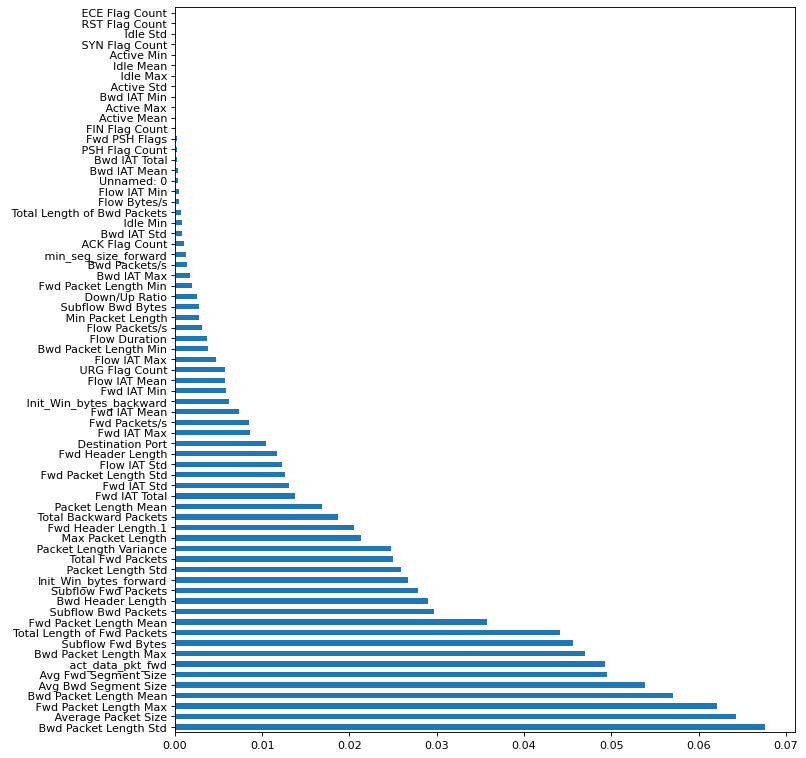

In [ ]:
# Revisemos las características por importancia

plt.figure(num=None, figsize=(10,12), dpi=80, facecolor='w', edgecolor='k')

feat_importances = pd.Series(clf.feature_importances_, index=ds_v4.iloc[: , :69].columns)

feat_importances.nlargest(69).plot(kind='barh')

Desde el punto de vista telemático, me parece importante contar con la información del puerto de destino, ya que nuestros ataques van ligados fuertemente a esta caracterísitica. He decidido realizar el corte de características importantes justo cuando se se incluye **Destination Port**.

Además, buscando realizar la conversión a una imagen cuadrada para CNN, optamos por dejar las 36 caracterísitcas más representativas cubriendo así **Destination Port**

In [ ]:
with pd.option_context('display.max_rows', None,): 
    display(feat_importances.nlargest(36))

 Bwd Packet Length Std         0.067658
 Average Packet Size           0.064245
 Fwd Packet Length Max         0.062113
 Bwd Packet Length Mean        0.057029
 Avg Bwd Segment Size          0.053920
 Avg Fwd Segment Size          0.049532
 act_data_pkt_fwd              0.049247
Bwd Packet Length Max          0.046998
 Subflow Fwd Bytes             0.045646
Total Length of Fwd Packets    0.044121
 Fwd Packet Length Mean        0.035790
 Subflow Bwd Packets           0.029715
 Bwd Header Length             0.028958
Subflow Fwd Packets            0.027863
Init_Win_bytes_forward         0.026722
 Packet Length Std             0.025851
 Total Fwd Packets             0.025025
 Packet Length Variance        0.024732
 Max Packet Length             0.021318
 Fwd Header Length.1           0.020470
 Total Backward Packets        0.018683
 Packet Length Mean            0.016851
Fwd IAT Total                  0.013793
 Fwd IAT Std                   0.013119
 Fwd Packet Length Std         0.012562


Caracterísitcas que serán eliminadas por su baja importancia

In [ ]:
col_retain = feat_importances.nsmallest(33).index
print(col_retain)

Index([' RST Flag Count', ' ECE Flag Count', ' Idle Std', ' SYN Flag Count',
       ' Active Min', 'Idle Mean', ' Idle Max', ' Active Std', ' Bwd IAT Min',
       ' Active Max', 'Active Mean', 'FIN Flag Count', 'Fwd PSH Flags',
       ' PSH Flag Count', 'Bwd IAT Total', ' Bwd IAT Mean', 'Unnamed: 0',
       ' Flow IAT Min', 'Flow Bytes/s', ' Total Length of Bwd Packets',
       ' Idle Min', ' Bwd IAT Std', ' ACK Flag Count', ' min_seg_size_forward',
       ' Bwd Packets/s', ' Bwd IAT Max', ' Fwd Packet Length Min',
       ' Down/Up Ratio', ' Subflow Bwd Bytes', ' Min Packet Length',
       ' Flow Packets/s', ' Flow Duration', ' Bwd Packet Length Min'],
      dtype='object')


Ajustamos el dataset

In [ ]:
# Eliminando las columnas menos significativas
col_drop = col_retain.tolist()

ds_v4 = ds_v4.drop(col_drop, axis=1)

Validemos las nuevas dimensiones del dataset

In [ ]:
ds_v4.shape

(1187782, 37)

## El tráfico benigno representa el doble de tráfico malicioso

Revisaremos si esta proporción presenta problemas y si al balancear los datos obtenemos cambios significativos.

Primero entrenaremos un modelo sin ningún tipo de balanceo

In [ ]:
# Separamos las entradas de la salida
X = ds_v4.drop(columns=({'Class'}))
y = ds_v4['Class']

# Estandarizamos los datos
scaler = MinMaxScaler()       
X_sc = scaler.fit_transform(X)   

# Dividimos lo datos para entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_sc, y, train_size=0.7, random_state=1)

In [ ]:
print('Distribución de las clases para entrenamiento')
print(y_train.value_counts())
print(' ')
print('Distribución de las clases para prueba')
print(y_test.value_counts())

Distribución de las clases para entrenamiento
1    558412
0    268475
2      3161
3      1355
4        44
Name: Class, dtype: int64
 
Distribución de las clases para prueba
1    239368
0    114955
2      1389
3       607
4        16
Name: Class, dtype: int64


Validaremos el impacto del desbalance entre el tráfico BENIGNO y los ATAQUES.

In [ ]:
# Convertimos las clases en un problema binario
y_train_bin = y_train.replace([2, 3, 4], 0)
y_test_bin = y_test.replace([2, 3, 4], 0)
dict_bin = {0: 'ATTACK', 1: 'BENIGN'}
print('Caso binario', dict_bin)
print(' ')
print('Distribución de las clases para entrenamiento')
print(y_train_bin.value_counts())
print(' ')
print('Distribución de las clases para prueba')
print(y_test_bin.value_counts())

Caso binario {0: 'ATTACK', 1: 'BENIGN'}
 
Distribución de las clases para entrenamiento
1    558412
0    273035
Name: Class, dtype: int64
 
Distribución de las clases para prueba
1    239368
0    116967
Name: Class, dtype: int64


In [ ]:
clf = LogisticRegression(max_iter=500)

clf = clf.fit(X_train, y_train_bin)
y_pred_train = clf.predict(X_train)
y_pred = clf.predict(X_test)

Entrenamiento: Accuracy:  0.9788429088083787  F1-Score:  0.9758392492294281
Validación: Accuracy:  0.9789692283946286  F1-Score:  0.9759766148001274


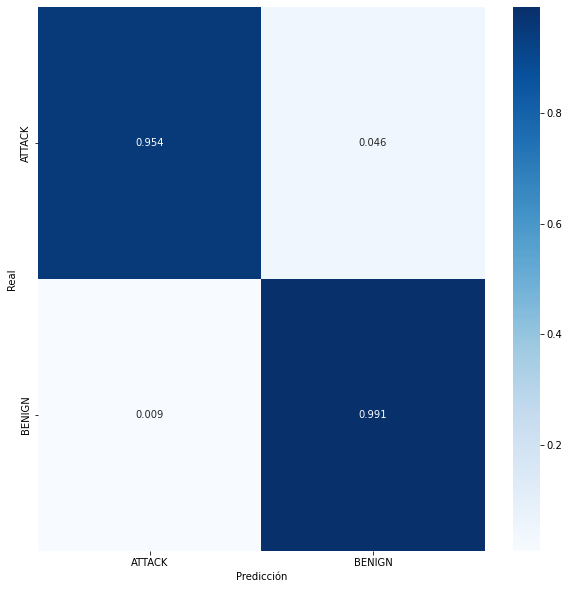

In [ ]:
print("Entrenamiento: Accuracy: ",accuracy_score(y_train_bin,y_pred_train), " F1-Score: ", f1_score(y_train_bin,y_pred_train, average = "macro"))
print("Validación: Accuracy: ",accuracy_score(y_test_bin,y_pred), " F1-Score: ", f1_score(y_test_bin,y_pred , average = "macro"))

matrix_conf(y_test_bin, y_pred, dict_bin.values())

Ahora aplicaremos un submuestreo aleatorio, eliminando elementos de la clase mayoritaria de forma aleatoria para balancear las clases.

In [ ]:
n_min = ds_v4[ds_v4['Class'] != 1].shape[0]
print("Mínimo número tomado de la clase minoritaria: ",n_min)

Mínimo número tomado de la clase minoritaria:  390002


In [ ]:
clase_0 = ds_v4[ds_v4['Class'] != 1]
clase_1 = ds_v4[ds_v4['Class'] == 1].sample(n_min)

ds_v5 = pd.concat([clase_0,clase_1])
ds_v5.shape

(780004, 37)

In [ ]:
ds_v5['Class'].value_counts()

1    390002
0    383430
2      4550
3      1962
4        60
Name: Class, dtype: int64

In [ ]:
X = ds_v5.drop(['Class'],axis = 1)
y = ds_v5['Class']

In [ ]:
# Estandarizamos los datos
scaler = MinMaxScaler()       
X_sc = scaler.fit_transform(X)   

# Dividimos lo datos para entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_sc, y, train_size=0.7, random_state=1)

# Convertimos las clases en un problema binario
y_train_bin = y_train.replace([2, 3, 4], 0)
y_test_bin = y_test.replace([2, 3, 4], 0)

In [ ]:
print('Datos para entrenamiento')
print(X_train.shape[0])
print(' ')
print('Datos para prueba')
print(X_test.shape[0])

Datos para entrenamiento
546002
 
Datos para prueba
234002


Entrenamos nuevamente el modelo

In [ ]:
clf = LogisticRegression(max_iter=500)

clf = clf.fit(X_train, y_train_bin)
y_pred_train = clf.predict(X_train)
y_pred = clf.predict(X_test)

Entrenamiento: Accuracy:  0.9792729696960817  F1-Score:  0.9792727257862646
Validación: Accuracy:  0.9788719754532013  F1-Score:  0.9788719749531383


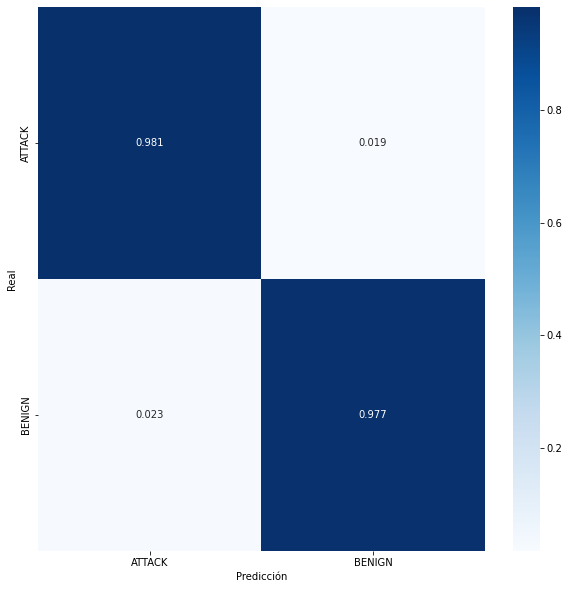

In [ ]:
print("Entrenamiento: Accuracy: ",accuracy_score(y_train_bin,y_pred_train), " F1-Score: ", f1_score(y_train_bin,y_pred_train, average = "macro"))
print("Validación: Accuracy: ",accuracy_score(y_test_bin,y_pred), " F1-Score: ", f1_score(y_test_bin,y_pred , average = "macro"))

matrix_conf(y_test_bin, y_pred, dict_bin.values())